In [41]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt

from multiview_consistency import all_views_processed, retrieve_keypts, retrieve_common_id, select_keypoints_athlete, create_dict_all_detections, plot_view_consistency
%matplotlib widget


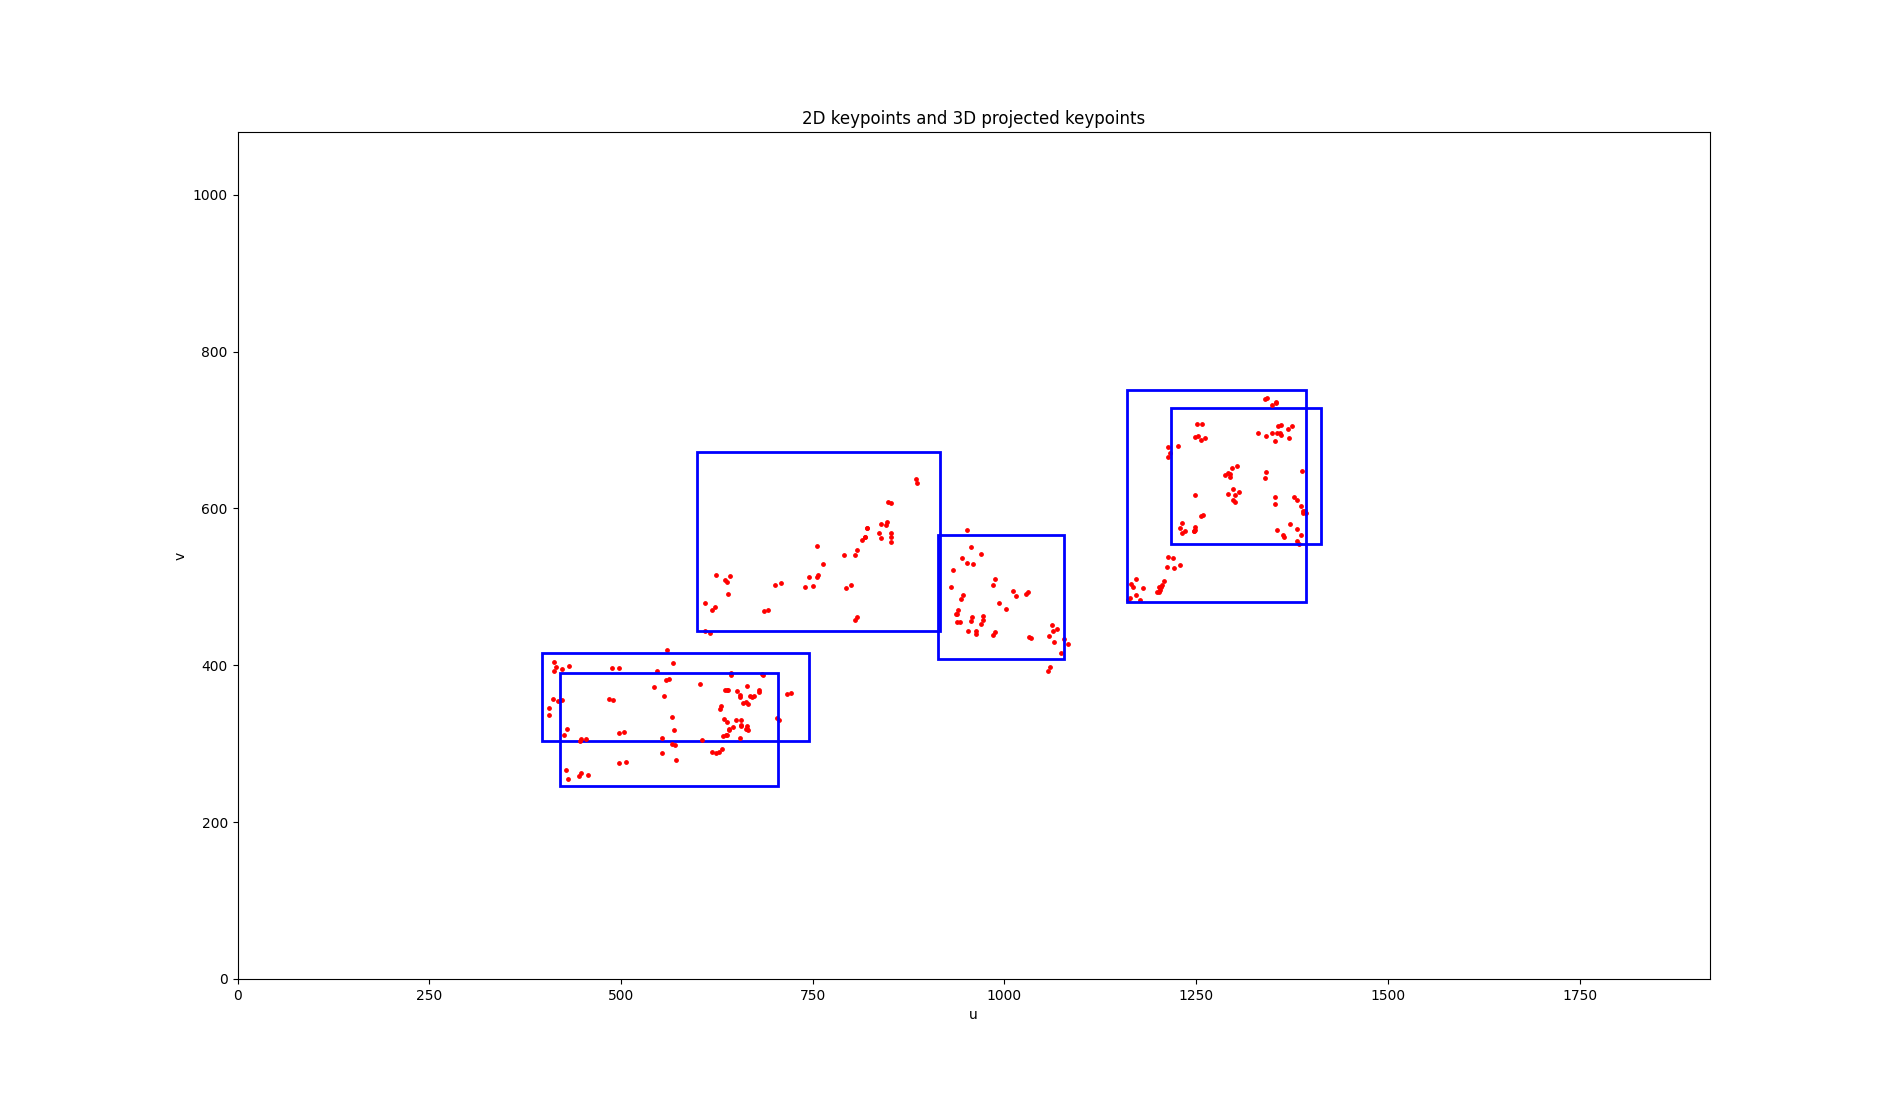

In [ ]:
path = '/home/lea/trampo/4DHumans/outputs/results'

f = 5000
im_resize = 256

K = np.array([[f/256, 0, 0],
              [0, f/256, 0],
              [0, 0, 1]])
R = np.eye(3)

fig, ax = plt.subplots(figsize=(19,11))

for file in sorted(os.listdir(path)):
    all_keypoints = {}
    keypoint_pkl_path = None

    results = joblib.load(os.path.join(path, file))

    # Output setup
    json_output_dir = os.path.join('SMPL_keypoints', file.replace('demo_', '').split('.')[0] + '_json')
    pkl_output_dir = 'SMPL_keypoints'

    # Loop on all frames
    for frame in results: #['outputs//_DEMO/1_partie_0429-Camera1_M11139/img/000032.jpg']
        frame_res = results[frame]
        if len(frame_res['smpl']) == 0:
            continue

        keypoints = []
        keypoints_per_frame = []
        # Loop on detected ids
        for i, output in enumerate(frame_res['smpl']):
            try:
                id = frame_res['tracked_ids'][i]
            except IndexError:
                id = -1
            
            frame_idx = frame_res['time']
            bbox = frame_res['bbox'][i]
            center = frame_res['center'][i]
            size = frame_res['size'][i]
            cam_trans = frame_res['camera'][i]
            conf = frame_res['conf'][i]
            conf = np.ones((45,1)) * conf

            joints_2d = frame_res['2d_joints'][i]
            joints_2d = np.array(joints_2d).reshape((45,2))

            joints_3d = frame_res['3d_joints'][i]
            joints_3d = np.array(joints_3d).reshape((45,3))

            if frame_idx % 200 == 0:
                points = joints_3d + cam_trans # (4,3)

                proj = (K @ R @ points.T).T # (4,3)
                proj_norm = proj[:,:2] / proj[:,2].reshape(-1,1)
                proj_norm *= max(size)
                proj_norm += np.array(size[::-1])/2

                ax.scatter(proj_norm[:,0], proj_norm[:,1], s=6, label='Projected 3D points', color='red')

                xmin, ymin, width, height = bbox
                bbox_plt = plt.Rectangle((xmin, ymin), width, height,
                                                linewidth=2, edgecolor='blue', facecolor='none')
                ax.add_patch(bbox_plt)

            break
        #break
    break

ax.set_xlim(0,1920)
ax.set_xlabel('u')
ax.set_ylim(0,1080)
ax.set_ylabel('v')
plt.title('2D keypoints and 3D projected keypoints')
plt.show()

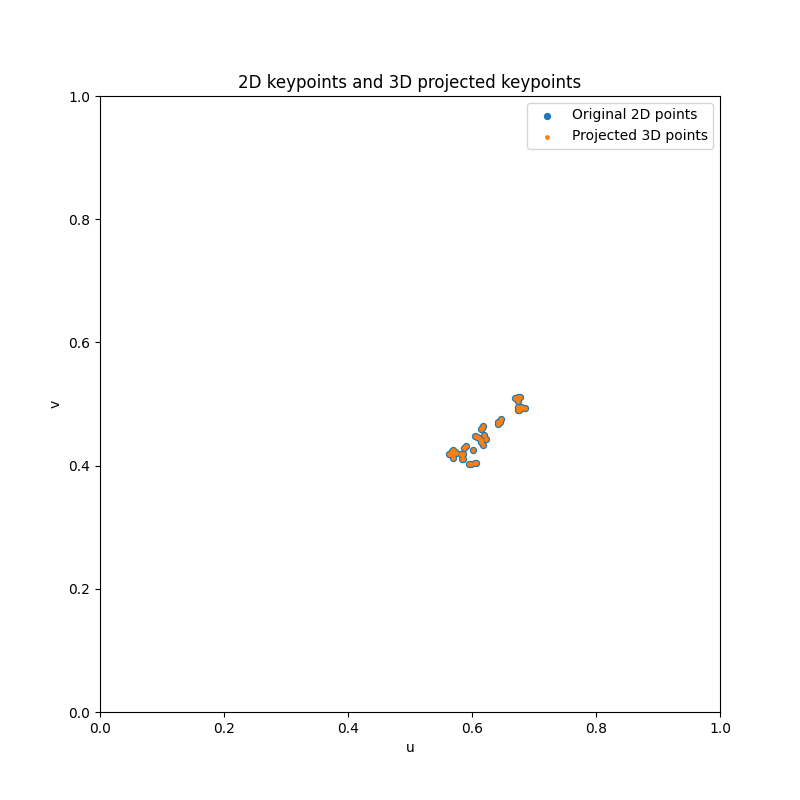

In [82]:
pts2d = joints_2d
#print('Points 2d \n', pts2d)
pts3d = joints_3d
#print('Points 3d \n', pts3d)
f = 5000
im_resize = 256

K = np.array([[f/im_resize, 0, 0.5],
              [0, f/im_resize, 0.5],
              [0, 0, 1]])
R = np.eye(3)

points = pts3d + cam_trans # (4,3)

#print('Translated points \n', points)
#projected_points = points[:] / points[:,-1]

proj = (K @ R @ points.T).T # (4,3)
proj_norm = proj[:,:2] / proj[:,2].reshape(-1,1)
#print('Projection normalized \n', proj_norm)

fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(pts2d[:,0], pts2d[:,1], s=18, label='Original 2D points')
ax.scatter(proj_norm[:,0], proj_norm[:,1], s=6, label='Projected 3D points')

ax.set_xlim(0,1)
ax.set_xlabel('u')
ax.set_ylim(0,1)
ax.set_ylabel('v')
plt.title('2D keypoints and 3D projected keypoints')
plt.legend()
plt.show()